# **COMP 2211 Exploring Artificial Intelligence**
## Image Classification (CNN)

![cnn.png](https://miro.medium.com/max/1400/1*irWQaiIjHS27ZAPaVDoj6w.png)

## **Review** ##
Before we start, let's have a quick recap of the lecture. We will go through the recap using the handwritten digits dataset, MNIST, as an example.

As we will train a CNN model on MNIST, let's first enable GPU acceleration to speed up the training process.

**Enable the GPU accelerator in Colab:**

1. 'Edit' -> 'Notebook settings':

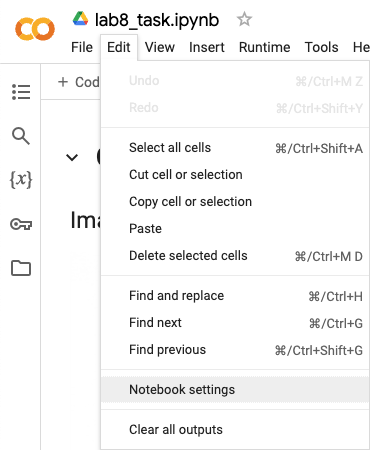

2. Set 'Hardware accelerator' to  GPU:

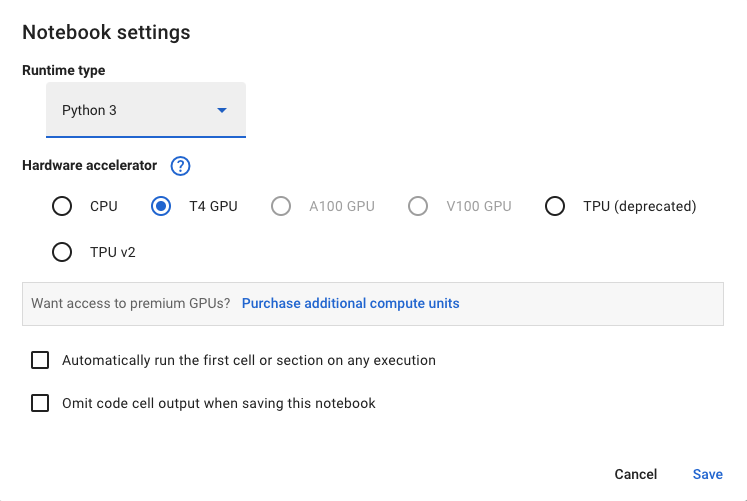

## Check if GPU is enabled

In [1]:
# check your Colab device
import tensorflow as tf # Import tensorflow library
import pprint           # Import pprint library for better print format

device_name = tf.config.list_physical_devices() # A list of divece name, which could contain CPU and GPU
pprint.pprint(device_name)                      # Print the device_name

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


***Note:*** If you use GPU too regularly, runtime durations will become shorter and shorter, and disconnections more frequent. The cooldown period before you can connect to another GPU will extend from hours to days to weeks.

## Procedure of training a CNN for image classification

1. Import required libraries and define global variables
2. Data preprocessing
3. Build the model
4. Compile the model
5. Train the model
6. Evalutate the model
7. Save the model

## 1. Import required libraries and define global variables

In [2]:
import numpy as np                                                     # Import numpy library
import matplotlib.pyplot as plt                                        # Import mathplot library
import datetime                                                        # Import datetime library
from pprint import pprint                                              # Import pprint library
from keras.datasets import mnist                                       # Import MNIST dataset
from keras.models import Sequential                                    # Import Sequential class
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten # Import Conv2D, MaxPooling2D, Dense, Dropout, Flatten class
from keras.utils import to_categorical                                 # Import to categorical utilities

batch_size = 128             # Number of samples per gradient update
num_classes = 10             # Number of classes in the dataset
epochs = 10                  # Number of epochs to train the model
img_rows, img_cols = 28, 28  # Image dimensions

## 2. Data preprocessing

Keras provides a convenient interface for loading the MNIST dataset. We can simply use it to load the dataset.

In [3]:
# Load MNIST dataset
# x_train is a NumPy array of grayscale image data with shape (60000, 28, 28)
# y_train is a NumPy array of digit labels (in range 0-9) with shape (60000,)
# x_test is a NumPy array of grayscale image data with shape (10000, 28, 28)
# y_test is a NumPy array of digit labels (in range 0-9) with shape (10000,)
(x_train, y_train), (x_test, y_test) = mnist.load_data() # Load MNIST dataset from Keras
print('Shape of train set: {}, Shape of test set: {}'.format(x_train.shape, x_test.shape))

Shape of train set: (60000, 28, 28), Shape of test set: (10000, 28, 28)


The MNIST dataset consists of handwritten digits from 0 to 9.

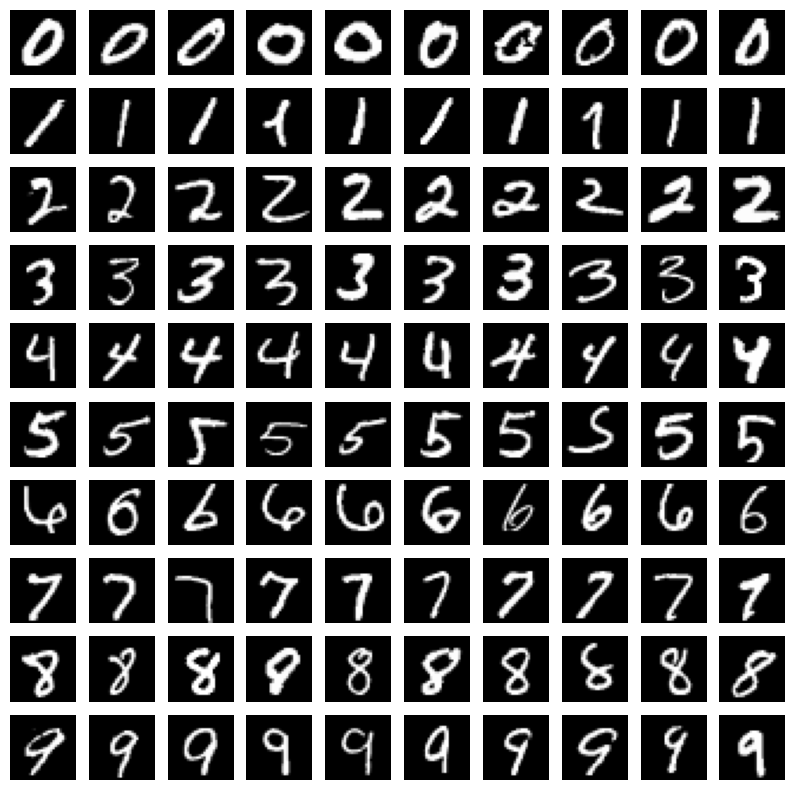

In [4]:
# Show some samples from MNIST dataset
import random, time
num_samples = 10
random.seed(time.time())
indices = list(range(len(y_train)))
random.shuffle(indices)
digit_images = {i: [] for i in range(10)}
for i in indices:
    digit = y_train[i]
    if len(digit_images[digit]) < num_samples:
        digit_images[digit].append(x_train[i])
fig, axs = plt.subplots(10, num_samples, figsize=(num_samples, 10))
for i in range(10):
    for j in range(num_samples):
        axs[i, j].imshow(digit_images[i][j], cmap='gray')
        axs[i, j].axis('off')
plt.show()

Perform the data preprocessing:

In [5]:
# Reshape the data to 4-dimension. The last dimension represent the number of channels.
x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)

# There are 10 classes and classes are represented as unique integers(0 to 9).
# To do so, transforming the integer into a 10 element binary vector.
# eg. [2] -> [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y_train = to_categorical(y_train, num_classes)  # Shape from (60000,) -> (60000, 10)
y_test = to_categorical(y_test, num_classes)    # Shape from (10000,) -> (10000, 10)

print('Shape of y_train: {}, Shape of y_test: {}'.format(y_train.shape, y_test.shape))

Shape of y_train: (60000, 10), Shape of y_test: (10000, 10)


## 3. Build the Model

CNN consists of three main types of layers: **Convolutional (Conv) Layer**, **Pooling Layer**, and **Fully Connected (FC) Layer**

> General Pipeline of CNN: Input -> **Conv Layers** and **Pooling Layers** -> Flatten Operation -> **FC Layers** -> Output

### Convolutional Layer
- Convolution
- Activation

### Pooling Layer
- Max pooling, average pooling, etc.

### FC Layer
- Dense Layer (a.k.a. Linear Layer)
- Activation

### Other Layers
- Dropout Layer
- ...

There are two ways to build a sequential CNN model in Keras:


In [6]:
# Create the model

# Method 1
model = Sequential()  # Create a Sequential object
# ----- Convolutional Layer -----
# Add a convolutional layer with 32 kernels, each of size 3x3
# Use ReLU activation function, padding='valid', strides=(1, 1)
# Specify the input size to this convolutional layer: (28, 28, 1)
# Note: Input size needs to be specified for the first layer only
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
# Add another convolutional layer with 64 kernels, each of size 3x3
# Use ReLU activation function, padding='valid', strides=(1, 1)
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
# Add a max pooling layer of size 2x2
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add a dropout layer to prevent a model from overfitting
model.add(Dropout(0.1))
# -------------------------------
# Add a flatten layer to convert the pooled data to a single column
model.add(Flatten())  # Flatten operation. Shape from (B, H, W, C) -> (B, H*W*C)
# ---------- FC Layer -----------
# Add a dense layer (fully-connected layer) and use ReLU activation function
model.add(Dense(units=128, activation='relu'))
# Add a dense layer (fully-connected layer) and use Softmax activation function
model.add(Dense(units=10, activation='softmax'))

# Method 2
model2 = Sequential(
    [Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),  # Add a convolutional layer with 32 kernels, each of size 3x3
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),                            # Add another convolutional layer with 64 kernels, each of size 3x3
    MaxPooling2D(pool_size=(2, 2)),                                                       # Add a max pooling layer of size 2x2
    Dropout(0.1),                                                                         # Add a dropout layer to prevent a model from overfitting
    Flatten(),                                                                            # Add a flatten layer to convert the pooled data to a single column
    Dense(units=128, activation='relu'),                                                  # Add a dense layer (fully-connected layer) and use ReLU activation function
    Dense(units=10, activation='softmax')]                                                # Add a dense layer (fully-connected layer) and use Softmax activation function
)

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

## 4. Compile the Model
- Optimizer: 'adam' or 'sgd'. 'adam' usually leads to faster convergence.
- Loss: 'categorical_crossentropy' for classification task.
- Metrics: 'accuracy' for classification task.

In [8]:
# Compile the model, i.e., configures the model for training
# Use crossentropy loss function since there are two or more label classes
# Use adam algorithm (a stochastic gradient descent method)
# Use accuracy as metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## 5. Train the Model

In [9]:
# Fit the model, i.e., train the model
# Specify training data and labels
# Specify batch size, i.e., number of samples per gradient update
# Specify epochs, i.e., number of times the entire training dataset is passed
# Specify validation data, i.e., data on which to evaluate the loss
training_history = model.fit(x_train, y_train,
                             batch_size=batch_size,
                             epochs=epochs,
                             validation_data=(x_test, y_test))

Epoch 1/10
469/469 [==============================] - 11s 8ms/step - loss: 0.9574 - accuracy: 0.9339 - val_loss: 0.0660 - val_accuracy: 0.9785
Epoch 2/10
469/469 [==============================] - 3s 7ms/step - loss: 0.0539 - accuracy: 0.9833 - val_loss: 0.0593 - val_accuracy: 0.9828
Epoch 3/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0378 - accuracy: 0.9877 - val_loss: 0.0476 - val_accuracy: 0.9860
Epoch 4/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0278 - accuracy: 0.9911 - val_loss: 0.0528 - val_accuracy: 0.9852
Epoch 5/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0221 - accuracy: 0.9927 - val_loss: 0.0570 - val_accuracy: 0.9830
Epoch 6/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0184 - accuracy: 0.9939 - val_loss: 0.0540 - val_accuracy: 0.9863
Epoch 7/10
469/469 [==============================] - 3s 6ms/step - loss: 0.0187 - accuracy: 0.9936 - val_loss: 0.0509 - val_accuracy: 0.9867
Epoch

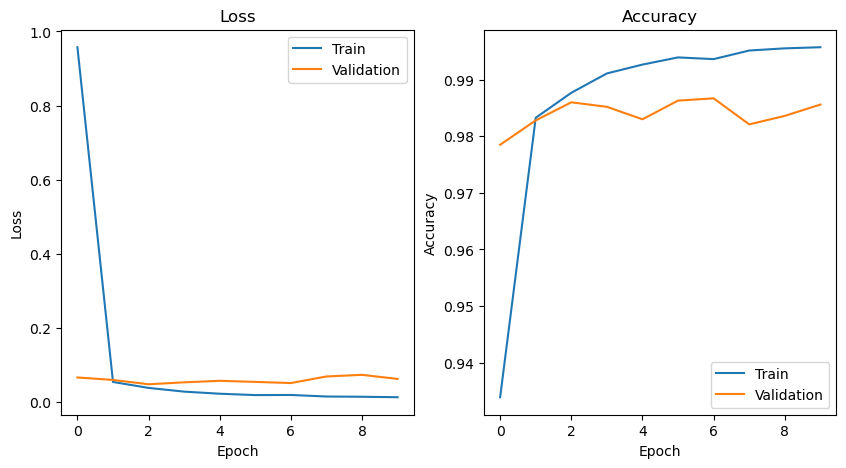

In [10]:
# Visualize the Loss and Accuracy from training_history
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(training_history.history['loss'])          # Plot the training loss
plt.plot(training_history.history['val_loss'])      # Plot the validation loss
plt.title('Loss')                               # Set the title
plt.xlabel('Epoch')                             # Set the label of x axis
plt.ylabel('Loss')                              # Set the label of y axis
plt.legend(['Train', 'Validation'])             # Set the legend

plt.subplot(1, 2, 2)
plt.plot(training_history.history['accuracy'])      # Plot the training accuracy
plt.plot(training_history.history['val_accuracy'])  # Plot the validation accuracy
plt.title('Accuracy')                           # Set the title
plt.xlabel('Epoch')                             # Set the label of x axis
plt.ylabel('Accuracy')                          # Set the label of y axis
plt.legend(['Train', 'Validation'])             # Set the legend

plt.show()                                         # Display the figure window

## 6. Evaluate the Model

In [11]:
# Evaluate the model
# Specify test data and labels
# Set verbose to 0, i.e., slient (no progress bar)
val_loss, val_acc = model.evaluate(x_test, y_test, verbose=0)  # verbose=0 means no progress bar
print('Validation loss: {}'.format(val_loss))
print('Validation accuracy: {}'.format(val_acc))

Validation loss: 0.06205250695347786
Validation accuracy: 0.9855999946594238


## 7. Save the Model

In [12]:
# Save the mdoel to a keras file
model_name = 'my_model.keras'                # define model name
model.save(model_name)  # save the model

## An Interesting Website for CNN Visualization
> https://poloclub.github.io/cnn-explainer/

![web.gif](https://poloclub.github.io/cnn-explainer/assets/figures/convlayer_overview_demo.gif)